In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from copy import deepcopy

from scipy.interpolate import RegularGridInterpolator
from scipy.stats import binned_statistic_2d
from sklearn.linear_model import LinearRegression

from utils import *

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch, ConnectionPatch
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.ticker import LogLocator, MaxNLocator, NullLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from matplotlib.path import Path
import matplotlib.gridspec as gridspec

sns.set(
    context='paper',
    font_scale=2.2,
    font="Arial",
    palette='deep',
    style='ticks',
    color_codes=True,
    rc={
        "mathtext.fontset": "cm",
        "axes.linewidth": 2,
        "font.size": 16,
        "figure.dpi": 100,
        "text.usetex": False,
        "lines.linewidth": 2,
        "axes.labelpad": 0,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.major.size": 6,
        "ytick.major.size": 6,
        "xtick.major.width": 3,
        "ytick.major.width": 3,
        "xtick.minor.size": 3,
        "ytick.minor.size": 3,
    }
)

import warnings
warnings.filterwarnings("ignore")


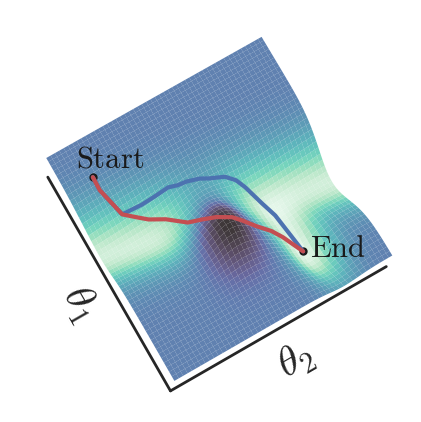

In [2]:
# ========== 1. Create grid and loss surface ==========
x = np.linspace(-4, 4, 300)
y = np.linspace(-3, 3, 300)
X, Y = np.meshgrid(x, y)

# Define loss surface components
central_peak = 1.4 * np.exp(-(((X + 0.2)**2 + (Y + 0.4)**2) / 1))
valley_main = 1 - np.exp(-((Y - 0.1 + 0.15 * X)**2) / 1)
valley_second = -np.exp(-((X - 2)**2) / 0.6) * np.exp(-((Y + 1 + 0.4 * X)**2) / 1)

# Combine and normalize
Z = central_peak + (valley_main + valley_second)
Z = (Z - Z.min()) / (Z.max() - Z.min())

# ========== 2. Define closed- and open-loop paths ==========
x_closed = np.array([-3, -3, -2.7, -2, -1.5, -1, -0.7, -0.4, 0, 0.3, 0.8, 1.1, 1.3, 1.6, 1.8, 2])
y_closed = np.array([2.1, 1.8, 1.2, 1.15, 1.14, 1.13, 1.05, 1.0, 0.9, 0.8, 0.7, 0.55, 0.35, -0.1, -0.5, -1.6])

x_open = np.array([-3, -3, -2.7, -2.5, -2.3, -2, -1.5, -1, -0.7, -0.4, 0, 0.3, 0.8, 1.1, 1.3, 1.6, 2])
y_open = np.array([2.1, 1.8, 1.2, 1.1, 1.0, 0.85, 0.65, 0.2, -0.1, -0.4, -0.6, -0.7, -0.8, -0.85, -0.9, -1.1, -1.6])

# Interpolate Z values for path points
interp_func = RegularGridInterpolator((x, y), Z.T)
z_closed = interp_func(np.column_stack((x_closed, y_closed)))
z_open = interp_func(np.column_stack((x_open, y_open)))

# ========== 3. Plotting ==========
fig = plt.figure(figsize=(7, 4.5))
ax = fig.add_subplot(111, projection='3d')

# -- Background --
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# -- Surface plot --
surf = ax.plot_surface(X, Y, Z, cmap='mako_r', alpha=0.8, edgecolor='none', zorder=0)

# -- Trajectories --
ax.plot(x_closed, y_closed, z_closed, color=sns.color_palette('deep')[0], lw=3, label=r'$\text{Closed-Loop}$', zorder=20)
ax.plot(x_open, y_open, z_open, color=sns.color_palette('deep')[3], lw=3, label=r'$\text{Open-Loop}$', zorder=20)

# -- Start/end points for closed-loop path --
ax.plot(x_closed[[0, -1]], y_closed[[0, -1]], z_closed[[0, -1]], 
        color='k', marker='o', lw=0, ms=5, zorder=10)

# ========== 4. Axis styling ==========
ax.set_xlabel(r'$\theta_2$', fontsize=30, labelpad=0)
ax.set_ylabel(r'$\theta_1$', fontsize=30, labelpad=0)
ax.set_zlabel('')
ax.set_zticks([]); ax.set_zticklabels([])
ax.set_xticks([]); ax.set_xticklabels([])
ax.set_yticks([]); ax.set_yticklabels([])
ax.zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))  # Hide z-axis line

# Remove 3D pane shading
for pane in [ax.xaxis.pane, ax.yaxis.pane, ax.zaxis.pane]:
    pane.set_edgecolor('w')
    pane.set_alpha(0)

# ========== 5. Annotations ==========
# Start and end text
ax.text(x_closed[0] - 0.3, y_closed[0] + 0.4, z_closed[0], r'$\text{Start}$', fontsize=22, color='k', zorder=30)
ax.text(x_closed[-1] + 0.1, y_closed[-1] - 0.2, z_closed[-1], r'$\text{End}$', fontsize=22, color='k', zorder=30)

# View settings
ax.view_init(elev=80, azim=240)
ax.grid(False)

# Limits
ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min() + 0.2, y.max())

# ========== 6. Export ==========
plt.tight_layout()
# plt.savefig('../figs/1_b.png', bbox_inches='tight', dpi=200)
plt.show()


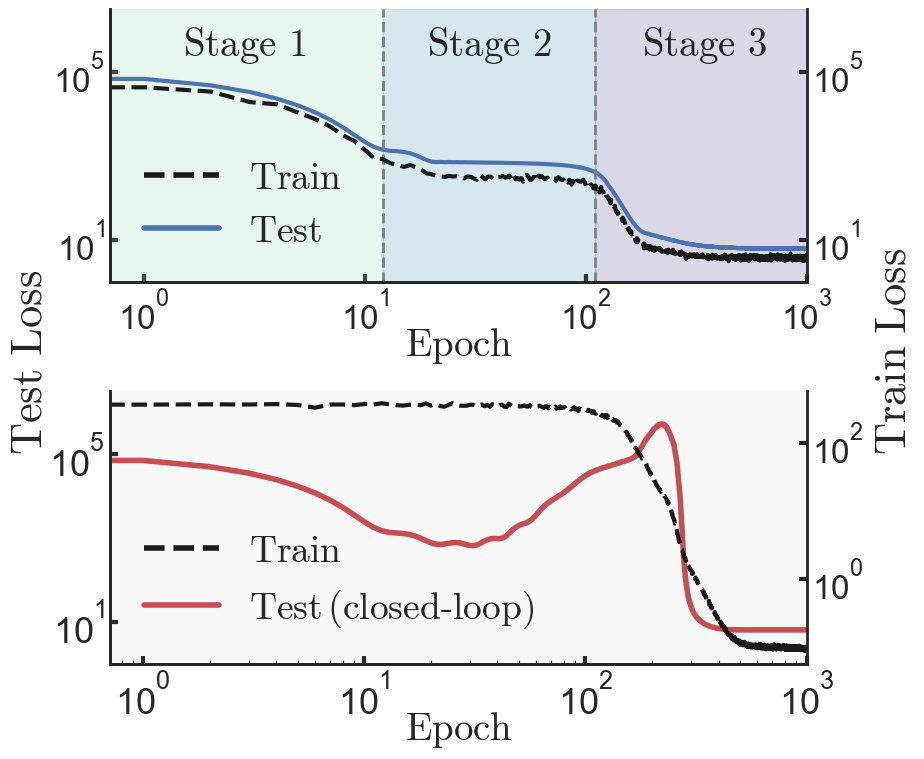

In [3]:
# load data 
with open('../data/non_linear_closed.pkl', 'rb') as f:
    loss, test_loss = pickle.load(f)

with open('../data/non_linear_open.pkl', 'rb') as f:
    loss2, test_loss2 = pickle.load(f)

# --- Setup figure and subplots ---
fig, (ax, ax1) = plt.subplots(
    2, 1,
    figsize=(9, 8.5),
    sharex=False,
    sharey=True,
    gridspec_kw={'hspace': .4}
)

# ========== Upper plot: Closed-loop test & train loss ==========
# -- Plot test loss curve (multi-colored by stage) --
x = np.arange(1000)
y = test_loss

colors = sns.color_palette('mako_r')
cmap = ListedColormap([colors[0], colors[2], colors[4]])

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
stage_index = np.zeros_like(x[:-1])
stage_index[:8] = 0
stage_index[8:129] = 1
stage_index[129:] = 2

# lc = LineCollection(segments, cmap=cmap, norm=Normalize(0, 2), linewidth=3)
# lc.set_array(stage_index)
# ax.add_collection(lc)
ax.plot(x, np.array(test_loss)[:1000], color=sns.color_palette('deep')[0], lw=3)

# -- Plot training loss on twin axis --
ax_tw = ax.twinx()
ax_tw.plot(x, np.array(loss)[:1000], '--k', lw=3)

# -- Background stage shading --
ax.axvspan(0, 12, color=colors[0], alpha=0.2)
ax.axvspan(12, 110, color=colors[2], alpha=0.2)
ax.axvspan(110, 1000, color=colors[4], alpha=0.2)

# -- Stage labels and lines --
ax.axvline(x=12, color='grey', ls='--')
ax.axvline(x=110, color='grey', ls='--')
ax.text(1.5, 10**5.4, r'$\text{Stage 1}$', size=28)
ax.text(19.1, 10**5.4, r'$\text{Stage 2}$', size=28)
ax.text(180, 10**5.4, r'$\text{Stage 3}$', size=28)

# -- Axis scaling and limits --
for axis in [ax, ax_tw]:
    axis.set_xscale('log')
    axis.set_yscale('log')
    axis.set_xlim(0.7, 1005)
    axis.set_ylim(1, 10**6.5)

ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=1))
ax_tw.yaxis.set_major_locator(LogLocator(base=10.0, numticks=1))
ax_tw.yaxis.set_tick_params(labelleft=False)
ax_tw.xaxis.set_minor_locator(NullLocator())
ax.xaxis.set_minor_locator(NullLocator())

# -- Legend --
ax.legend(
    handles=[
        Line2D([0], [0], color='k', linestyle='--', lw=4),
        Line2D([0], [0], color=sns.color_palette('deep')[0], linestyle='-', lw=4)
    ],
    labels=[r'$\text{Train}$', r'$\text{Test}$'],
    loc='lower left',
    frameon=False,
    fontsize=27
)

# ========== Lower plot: Open-loop ==========
ax1.plot(x, test_loss2, ls='-', color=sns.color_palette('deep')[3], lw=4, label=r'$\text{Open-Loop}$')
ax1.axvspan(0, 1000, color='grey', alpha=0.05)

# -- Twin y-axis for training loss --
ax1_tw = ax1.twinx()
ax1_tw.plot(x, np.array(loss2[:1000]), ls='--', color='k', lw=3)
ax1_tw.set_xscale('log')
ax1_tw.set_yscale('log')
ax1_tw.set_yticks([10**0, 10**2])
ax1_tw.yaxis.set_minor_locator(NullLocator())

# -- Labels --
ax1.text(2000, 10**5.2, r'$\text{Train}\,\,$' + r'$\text{Loss}$', size=32, rotation=90)
ax1.text(0.25, 10**5.2, r'$\text{Test}\,\,$' + r'$\text{Loss}$', size=32, rotation=90)

# -- Axis config --
ax1.set_xlim(-1, 1010)
ax1.set_xlabel(r'$\text{Epoch}$', size=28, labelpad=-8)
ax.set_xlabel(r'$\text{Epoch}$', size=28, labelpad=-8)
ax.set_yticks([10, 10**5])
ax_tw.set_yticks([10, 10**5])

# -- Font sizes --
for a in [ax, ax_tw, ax1, ax1_tw]:
    a.tick_params(axis='both', labelsize=24)

ax1.tick_params(axis='both', labelsize=26)

# -- Legend --
ax1.legend(
    handles=[
        Line2D([0], [0], color='k', linestyle='--', lw=4),
        Line2D([0], [0], color=sns.color_palette('deep')[3], linestyle='-', lw=4)
    ],
    labels=[r'$\text{Train}$', r'$\text{Test} \,\text{(closed-loop)}$'],
    loc='lower left',
    frameon=False,
    fontsize=27
)

# ========== Cleanup and display ==========
sns.despine()
ax.spines['right'].set_visible(True)
ax1_tw.spines['right'].set_visible(True)

for axx in [ax, ax1]:
    for label in axx.get_xticklabels():
        label.set_y(-0.01)

plt.tight_layout()
# plt.savefig('../figs/1c.pdf', bbox_inches='tight')
plt.show()


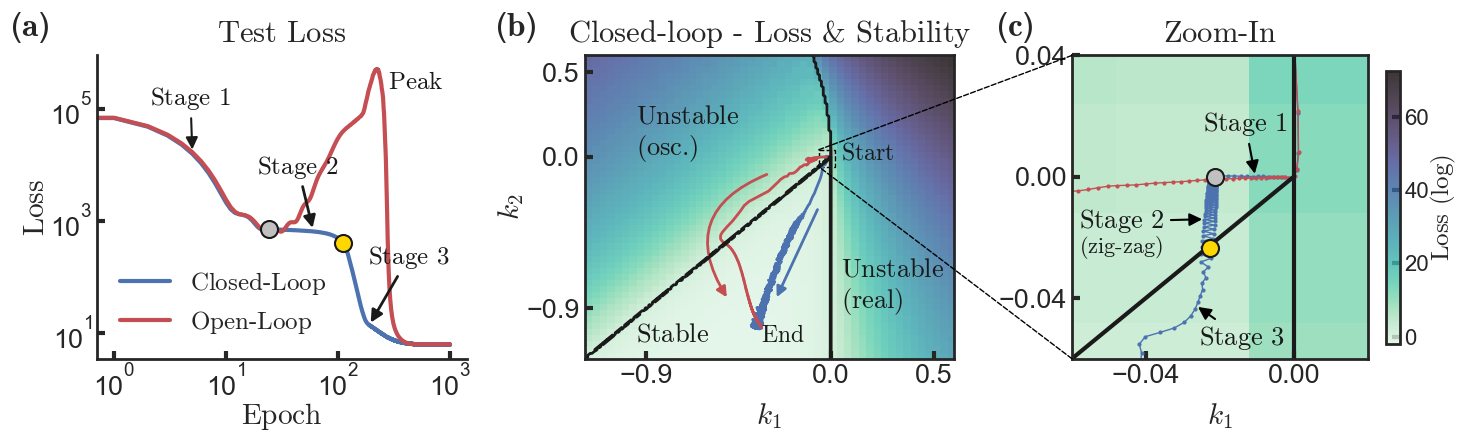

In [4]:
# ========== 1. Evaluate loss over LQR gain grid ==========

dt = 1
x_target = np.array([0.0, 0.0])
A = np.array([[1, dt], [0, 1]])
B = np.array([[0], [dt]])

Q = np.eye(2)
R = np.array([[1e-8]])  # Small R to avoid divide-by-zero in Riccati

P = scipy.linalg.solve_discrete_are(A, B, Q, R)
K = np.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)
K_LQR = K.copy()

all_k0 = np.linspace(-1.2, .6, 50)
all_k1 = np.linspace(-1.2, .6, 50)

kk0, kk1, zzz = [], [], []

for k0 in all_k0:
    for k1 in all_k1:
        K[0][0] = k0
        K[0][1] = k1

        num_steps = int(50 / dt)
        x = np.array([1.0, 1.0])
        loss = 0.0

        for _ in range(num_steps):
            u = K @ (x - x_target)
            x = A @ x + B.flatten() * u
            loss += np.sum((x - x_target)**2)

        kk0.append(k0)
        kk1.append(k1)
        zzz.append(np.log(loss / num_steps))

# ========== 2. Load learned gains from saved RNN controllers ==========
with open('../data/non_linear_all_k_eff.pkl', 'rb') as f:
    all_k = pickle.load(f)


# ========== 3. Stability classification over (k₁, k₂) ==========

all_a = np.linspace(-1.2, 0.6, 200)
all_b = np.linspace(-1.2, 0.6, 200)
all_stability = []

for a in all_a:
    for b in all_b:
        P_red = np.array([[1, 1], [a, 1 + b]])
        eigvals = np.linalg.eigvals(P_red)

        if np.all(np.abs(eigvals) < 1):
            label = 2  # Stable
        elif np.any((np.abs(eigvals) > 1) & (np.imag(eigvals) != 0)):
            label = 1  # Unstable (oscillatory)
        else:
            label = 0  # Unstable (real)

        all_stability.append(label)

X, Y = np.meshgrid(all_a, all_b)
Z = np.array(all_stability).reshape(len(all_b), len(all_a)).T

# ========== 4. Plotting: Loss, Trajectories, Stability ==========
fig, ax = plt.subplots(1, 3, figsize=(15, 4.8))

# === Panel (a): Test Loss ===
ax[0].plot(np.arange(1000), test_loss, color=sns.color_palette('deep')[0], lw=3, label=r'$\text{Closed-Loop}$')
ax[0].plot(np.arange(1000), test_loss2, color=sns.color_palette('deep')[3], lw=3, label=r'$\text{Open-Loop}$')
ax[0].set(xscale='log', yscale='log', xlabel=r'$\text{Epoch}$', ylabel=r"$\text{Loss}$")
ax[0].set_xticks([1, 10, 100, 1000])
ax[0].set_yticks([10, 1000, 100_000])
ax[0].legend(fontsize=18, loc='lower left', frameon=False)
ax[0].xaxis.set_minor_locator(NullLocator()); ax[0].yaxis.set_minor_locator(NullLocator())

# === Panel (b): Loss + Trajectories ===
im = ax[1].imshow(np.array(zzz).reshape(50, 50).T, extent=[-1.2, .6, -1.2, .6], origin="lower",
                  aspect="auto", cmap="mako_r", alpha=0.8)
for i in range(len(all_k)):
    ax[1].plot(all_k[i,:,0], all_k[i,:,1], lw=2, linestyle='-', color=sns.color_palette('deep')[i * 3])
ax[1].contour(X, Y, Z, levels=[0.5, 1.5], colors='k', linewidths=2)

# Region annotations
ax[1].text(0.05, -0.02, r'$\text{Start}$', fontsize=17, color='k', zorder=30)
ax[1].text(-0.34, -1.1, r'$\text{End}$', fontsize=17, color='k', zorder=30)
ax[1].text(-0.95, 0.01, r"$\text{Unstable}$"+'\n'+r"$\text{(osc.)}$", fontsize=19, weight='bold', color='k', zorder=30)
ax[1].text(0.05, -0.9, r"$\text{Unstable}$"+'\n'+r"$\text{(real)}$", fontsize=19, weight='bold', color='k', zorder=30)
ax[1].text(-0.95, -1.1, r"$\text{Stable}$", fontsize=19, weight='bold', color='k', zorder=30)
ax[1].set(xlabel=r"$k_1$", ylabel=r"$k_2$", xticks=[-.9, 0, .5], yticks=[-.9, 0, .5])

# === Panel (c): Zoom-In ===
im = ax[2].imshow(np.array(zzz).reshape(50, 50).T, extent=[-1.2, .6, -1.2, .6], origin="lower",
                  aspect="auto", cmap="mako_r", alpha=0.8)
cbar = fig.colorbar(im, ax=ax[2], shrink=0.9)
cbar.set_label(r'$\text{Loss (log)}$', fontsize=18); cbar.ax.tick_params(labelsize=16)
for i in range(len(all_k)):
    ax[2].plot(all_k[i,:,0], all_k[i,:,1], '.-', lw=1, ms=4, color=sns.color_palette('deep')[i * 3])
ax[2].set(xlim=(-0.06, 0.02), ylim=(-0.06, 0.04), xlabel=r"$k_1$", xticks=[-.04, 0], yticks=[-.04, 0, .04])

# === Zoom box and connectors ===
x0, x1 = -0.06, 0.02; y0, y1 = -0.06, 0.04
zoom_box = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=1, edgecolor='black', facecolor='none', linestyle='--')
ax[1].add_patch(zoom_box)
fig.add_artist(ConnectionPatch(xyA=(0, 1), coordsA="axes fraction", xyB=(x0, y1), coordsB="data",
                               axesA=ax[2], axesB=ax[1], arrowstyle="-", lw=1, linestyle='--', color="black"))
fig.add_artist(ConnectionPatch(xyA=(0, 0), coordsA="axes fraction", xyB=(x0, y0), coordsB="data",
                               axesA=ax[2], axesB=ax[1], arrowstyle="-", lw=1, linestyle='--', color="black"))

# === Arrows: trajectory movement ===
ax[1].add_patch(FancyArrowPatch((-0.06, -0.3), (-.27, -.85), connectionstyle="arc3,rad=0.0",
                                arrowstyle="-|>", lw=2, color=sns.color_palette('deep')[0], mutation_scale=15))
ax[1].add_patch(FancyArrowPatch((-0.3, -.1), (-.5, -.85), connectionstyle="arc3,rad=0.6",
                                arrowstyle="-|>", lw=2, color=sns.color_palette('deep')[3], mutation_scale=15))

# === Markers and Annotations ===
ax[0].scatter(24, test_loss[24], marker='o', color='silver', s=150, zorder=30, edgecolors='k', linewidths=1.5)
ax[0].scatter(110, test_loss[110], marker='o', color='gold', s=150, zorder=30, edgecolors='k', linewidths=1.5)
ax[2].scatter(all_k[0, 24, 0]-0.001, all_k[0, 24, 1], color='silver', s=150, zorder=30, edgecolors='k', linewidths=1.5)
ax[2].scatter(all_k[0, 110, 0]-0.0006, all_k[0, 110, 1]+0.001, color='gold', s=150, zorder=30, edgecolors='k', linewidths=1.5)

# === Stage text (loss panel) ===
ax[0].annotate(r'$\text{Stage 1}$', xy=(5, test_loss[5]+1e3), xytext=(2.1, test_loss[5]+1e5),
               arrowprops=dict(arrowstyle='-|>', color='k', lw=1.5), fontsize=18, color='k', zorder=30)
ax[0].annotate(r'$\text{Stage 2}$', xy=(60, test_loss[50]+2), xytext=(19, test_loss[50]+10**3.8),
               arrowprops=dict(arrowstyle='-|>', color='k', lw=2), fontsize=18, color='k', zorder=35)
ax[0].annotate(r'$\text{Stage 3}$', xy=(190, test_loss[190]), xytext=(185, test_loss[190]+10**2.2),
               arrowprops=dict(arrowstyle='-|>', color='k', lw=2), fontsize=18, color='k', zorder=32)
ax[0].annotate(r'$\text{Peak}$', xy=(210, 10**5.6), xytext=(280, 10**5.35),
               arrowprops=dict(arrowstyle='-', lw=0, color='k'), fontsize=18, color='k', zorder=30)

# === Stage text (zoom panel) ===
x1, y1 = all_k[0, 16]; ax[2].annotate(r'$\text{Stage 1}$', xy=(x1+0.0022, y1), xytext=(x1-0.012, y1+0.015),
                                     arrowprops=dict(arrowstyle='-|>', color='black', lw=1.5),
                                     fontsize=19, color='k', zorder=30)
ax[2].annotate(r'$\text{Stage 2}$', xy=(-0.024, -0.014), xytext=(-0.058, -0.017),
               arrowprops=dict(arrowstyle='-|>', color='black', lw=1.5), fontsize=19, color='k', zorder=30)
ax[2].annotate(r'$\text{(zig-zag)}$', xy=(-0.024, -0.014), xytext=(-0.058, -0.025),
               arrowprops=dict(arrowstyle='-', lw=0, color='black'), fontsize=16, color='k', zorder=30)
x2 = all_k[0, 120, 0]-0.0006; y2 = all_k[0, 120, 1]+0.001
ax[2].annotate(r'$\text{Stage 3}$', xy=(x2, y2-0.002), xytext=(x2+0.0008, y2-0.015),
               arrowprops=dict(arrowstyle='-|>', color='black', lw=1.5), fontsize=19, color='k', zorder=30)

# === Subplot labels and lines ===
for i, label in enumerate([r'($\mathbf{a}$)', r'($\mathbf{b}$)', r'($\mathbf{c}$)']):
    ax[i].text(-0.13, 1.15, label, transform=ax[i].transAxes, fontsize=24, va='top', ha='right', font="Arial")

ax[0].set_title(r'$\text{Test Loss}$', size=22, pad=10)
ax[1].set_title(r'$\text{Closed-loop - Loss & Stability}$', size=22, pad=10)
ax[2].set_title(r'$\text{Zoom-In}$', size=22, pad=10)
ax[2].axvline(x=0, color='k', lw=3)
ax[2].plot([0, -0.06], [0, -0.06], color='k', lw=3)

fig.align_xlabels(ax)
plt.tight_layout()
sns.despine(ax=ax[0])
# plt.savefig('../figs/fig_2.pdf', bbox_inches='tight')
plt.show()



In [5]:
# === Setup ===
N = 100
num_epochs = 1000
batch_size = 100
system = k_integrator_torch(k=2, dt=1, c=1, m=1)

# === Load teacher model training history ===
with open('../data/data_closed.pkl', 'rb') as f:
    loss, model_his_parameters, grad = pickle.load(f)

# === Compute test loss over epochs ===
test_loss = np.zeros((1, num_epochs))
x0 = np.random.uniform(-2, 2, (1, batch_size))
x1 = np.random.uniform(-2, 2, (1, batch_size))
h0 = np.zeros((model_his_parameters[0].N, batch_size))

for ep in range(num_epochs):
    model = model_his_parameters[ep]
    P = create_p_matrix_from_low_rank(model.system, model.N, model.M, model.Z, model.U, model.V, model.W_random)

    h = torch.tensor(np.vstack((x0, x1, h0)), dtype=torch.float32)
    traj = []
    for _ in range(50):
        traj.append(h[:2]**2)
        h = P @ h

    test_loss[0, ep] = torch.sum(torch.stack(traj), axis=1).mean().item()

# === Eigenvalue tracking of full P matrix ===
all_P = [
    create_p_matrix_from_low_rank(model.system, model.N, model.M, model.Z, model.U, model.V, model.W_random).detach().numpy()
    for model in model_his_parameters
]
eigvals = np.linalg.eig(np.array(all_P))[0]
stab = np.all(np.abs(eigvals) < 1, axis=1).astype(int)

# === Find stabilization epoch ===
ep_of_stab = next((i for i in range(num_epochs) if stab[i] == 1 and np.all(stab[i:] == 1)), num_epochs + 1)

# === Collect trajectories from key epochs ===
selected_epochs = [8, 140, 999]
all_traj = []

for ep in selected_epochs:
    model = model_his_parameters[ep]
    P = create_p_matrix_from_low_rank(model.system, model.N, model.M, model.Z, model.U, model.V, model.W_random)

    num_of_s = 300 if ep < 200 else 50  # Longer trace for earlier epochs
    x0 = np.array([1])
    x1 = np.array([-1])
    h0 = np.zeros((100, 1))

    h = torch.tensor(np.vstack((x0, x1, h0)), dtype=torch.float32)
    traj = []

    for _ in range(num_of_s):
        traj.append(h[:2])
        h = P @ h

    all_traj.append(torch.stack(traj).squeeze().detach().numpy()[:, 0])

# === Log-transformed loss trajectory segments ===
loss = test_loss[0]

x1 = np.arange(0, 12, 2)
y1 = np.log(loss[:12:2])

x2 = np.arange(12, ep_of_stab, 2)
y2 = np.log(loss[12:ep_of_stab:2])

x3 = np.arange(ep_of_stab, num_epochs, 2)
y3 = np.log(loss[ep_of_stab::2])


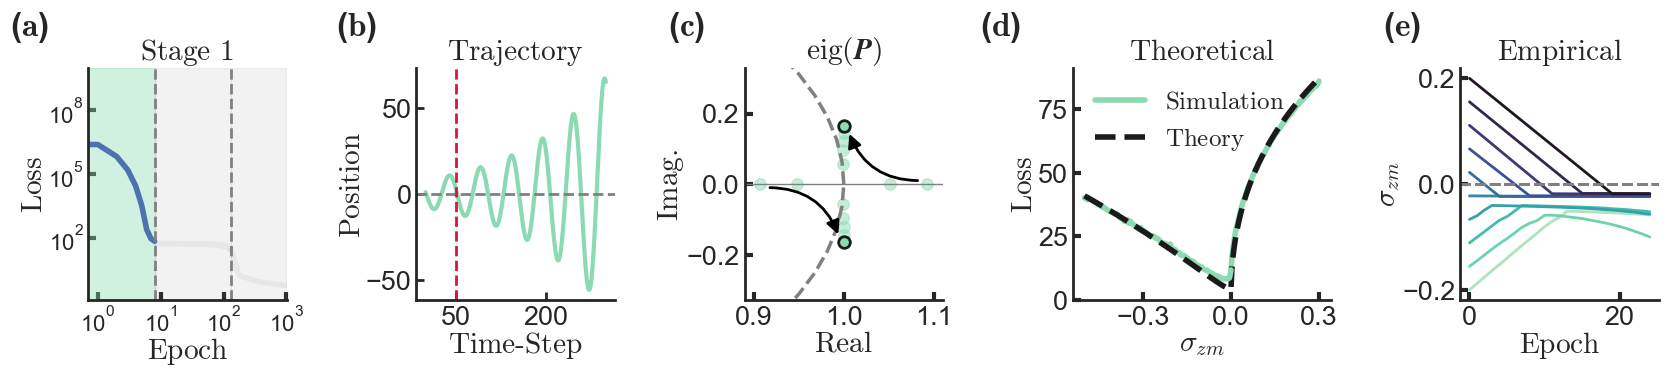

In [6]:
fig, ax = plt.subplots(1, 5, figsize=(17, 4.3), width_ratios=[1, 1, 1, 1.3, 1])

# === (a) Test Loss with stage annotations ===
ax[0].plot(np.arange(9), test_loss[0, :9], color=sns.color_palette('deep')[0], lw=4)
ax[0].plot(np.arange(8, 129), test_loss[0, 8:129], color=sns.color_palette('deep')[7], lw=4, alpha=0.1)
ax[0].plot(np.arange(129, 1000), test_loss[0, 129:], color=sns.color_palette('deep')[7], lw=4, alpha=0.1)

ax[0].axvspan(0, 8, color=sns.color_palette('mako_r')[0], alpha=0.4)
ax[0].axvspan(8, 129, color='grey', alpha=0.1)
ax[0].axvspan(129, 1000, color='grey', alpha=0.1)

ax[0].axvline(x=8, color='grey', ls='--')
ax[0].axvline(x=129, color='grey', ls='--')

ax[0].set(title=r"$\text{Stage 1}$", xlabel=r'$\text{Epoch}$', ylabel=r"$\text{Loss}$",
          xscale='log', yscale='log', xlim=(-10, 1010), ylim=(0.11, 10**10))
ax[0].set_xticks([1, 10, 100, 1000])
ax[0].tick_params(axis='both', labelsize=16)

# === (b) Trajectory ===
ax[1].plot(all_traj[0], lw=3, color=sns.color_palette('mako_r')[0])
ax[1].axhline(0, color='grey', linestyle='--', linewidth=2)
ax[1].axvline(x=50, ls='--', color='crimson')
ax[1].set(title=r"$\text{Trajectory}$", xlabel=r"$\text{Time-Step}$", ylabel=r"$\text{Position}$")
ax[1].set_xticks([50, 200])
ax[1].set_yticks([-50, 0, 50])
ax[1].tick_params(axis='both', which='major', width=2, length=6)

# === (c) eig(P) spectrum ===
eig, _ = np.linalg.eig(all_P[4])
ax[2].scatter(eig.real, eig.imag, s=70, color=sns.color_palette('mako_r')[0], alpha=0.5)

eig, _ = np.linalg.eig(all_P[10])
ax[2].scatter(eig.real, eig.imag, s=70, color=sns.color_palette('mako_r')[0],
              edgecolor='k', linewidths=2, zorder=30)

eig, _ = np.linalg.eig(all_P[5:10])
ax[2].scatter(eig.real, eig.imag, s=70, color=sns.color_palette('mako_r')[0], alpha=0.5)

circle = np.linspace(0, 2 * np.pi, 100)
ax[2].plot(np.cos(circle), np.sin(circle), color='grey', ls='--', lw=2.5)

ax[2].axhline(0, color='grey', lw=1)
ax[2].axvline(0, color='grey', lw=1)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set(title=r'$\text{eig}(\mathbfit{P})$', xlabel=r'$\text{Real}$', ylabel=r'$\text{Imag}.$',
          xlim=(0.89, 1.11), ylim=(-0.33, 0.33))

# Eig arrows
arrow3a = FancyArrowPatch((1.085, .01), (1.005, .15), connectionstyle="arc3,rad=-0.35",
                          arrowstyle="-|>", lw=2, color='black', mutation_scale=20, zorder=30)
arrow3b = FancyArrowPatch((0.915, -.01), (.995, -.15), connectionstyle="arc3,rad=-0.35",
                          arrowstyle="-|>", lw=2, color='black', mutation_scale=20, zorder=30)
ax[2].add_patch(arrow3a)
ax[2].add_patch(arrow3b)

# === Trajectory simulation and loss ===
def run_traj(P, num_steps=50):
    x0 = np.array([[1]])
    x1 = np.array([[-1]])
    h0 = np.zeros((model.N, 1))
    h = torch.tensor(np.vstack((x0, x1, h0)), dtype=torch.float32)

    traj = []
    for _ in range(num_steps):
        traj.append(h[:2].clone())
        h = P @ h

    return torch.cat(traj, dim=1).T.detach().numpy()  


num_steps = 100
N = 100

zm_pos = np.linspace(0.0001, 0.3, 100)
loss_sim_pos, loss_the_pos = [], []

for cur_zm in zm_pos:
    model = P_Model(N=N, g=0.0, system=system, over=cur_zm)
    P = create_p_matrix_from_low_rank(model.system, model.N, model.M, model.Z, model.U, model.V, model.W_random)
    traj = run_traj(P, num_steps)
    loss = np.sum(0.5 * (traj[:, 0]**2 + traj[:, 1]**2))
    loss_sim_pos.append(loss)

    T = num_steps + 1
    r = (np.abs(1 + np.sqrt(cur_zm + 0j))) ** 2
    loss_the_pos.append(0.5 * (1 - r**T) / (1 - r))

zm_neg = np.linspace(-0.5, -0.0001, 100)
loss_sim_neg, loss_the_neg = [], []

for cur_zm in zm_neg:
    model = P_Model(N=N, g=0.0, system=system, over=cur_zm)
    P = create_p_matrix_from_low_rank(model.system, model.N, model.M, model.Z, model.U, model.V, model.W_random)
    traj = run_traj(P, num_steps)
    loss = np.sum(0.5 * (traj[:, 0]**2 + traj[:, 1]**2))
    loss_sim_neg.append(loss)

    T = num_steps + 1
    r = (np.abs(1 + np.sqrt(cur_zm + 0j))) ** 2
    loss_the_neg.append(0.5 * (1 - r**T) / (1 - r))

# === (d) Plot theoretical vs simulation loss ===
ax[3].plot(zm_pos, np.log(loss_sim_pos), color=sns.color_palette('mako_r')[0], lw=4, label=r'$\text{Simulation}$')
ax[3].plot(zm_pos, np.log(loss_the_pos), '--k', lw=4, label=r'$\text{Theory}$')
ax[3].plot(zm_neg, np.log(loss_sim_neg), color=sns.color_palette('mako_r')[0], lw=4)
ax[3].plot(zm_neg, np.log(loss_the_neg), '--k', lw=4)

ax[3].legend(fontsize=18, loc='upper left', frameon=False)
ax[3].set(title=r'$\text{Theoretical}$', xlabel=r'$ \sigma_{zm} $', ylabel=r"$\text{Loss}$")
ax[3].set_xticks([-0.3, 0, 0.3])

# === (e) Overlap vs epoch for different initial σ_zm ===
zm_over_time = []
all_zm_vals = np.linspace(-0.2, 0.2, 10)
colors = sns.color_palette('mako_r', n_colors=len(all_zm_vals))

for i, cur_zm in enumerate(all_zm_vals):
    system = k_integrator_torch(k=2, dt=1, c=1, m=1)
    model = P_Model(N=100, g=0.0, system=system, over=cur_zm)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    loss, _model_his_parameters, grad = train_model_p(
        model, optimizer, teacher=None, white_noise=None,
        w_grad_clip=True, num_epochs=50, batch_size=100,
        num_steps=50, clamp=False)

    all_over = [(m.Z @ m.M).item() for m in _model_his_parameters]
    ax[4].plot(all_over[::2], label=cur_zm, color=colors[i], lw=2)
    ax[4].axhline(y=0, color='grey', ls='--', lw=2)
    zm_over_time.append(all_over)

ax[4].set(title=r'$\text{Empirical}$', xlabel=r'$\text{Epoch}$', ylabel=r'$ \sigma_{zm} $')

# === Subplot labels ===
subplot_labels = [r'($\mathbf{a}$)', r'($\mathbf{b}$)', r'($\mathbf{c}$)', r'($\mathbf{d}$)', r'($\mathbf{e}$)']
for i, label in enumerate(subplot_labels):
    ax[i].text(-0.2, 1.25, label, transform=ax[i].transAxes,
               fontsize=24, fontweight='bold', va='top', ha='right', font="Arial")

# === Final display ===
plt.tight_layout()
sns.despine()
# plt.savefig('../figs/fig_3.pdf', bbox_inches='tight')
plt.show()


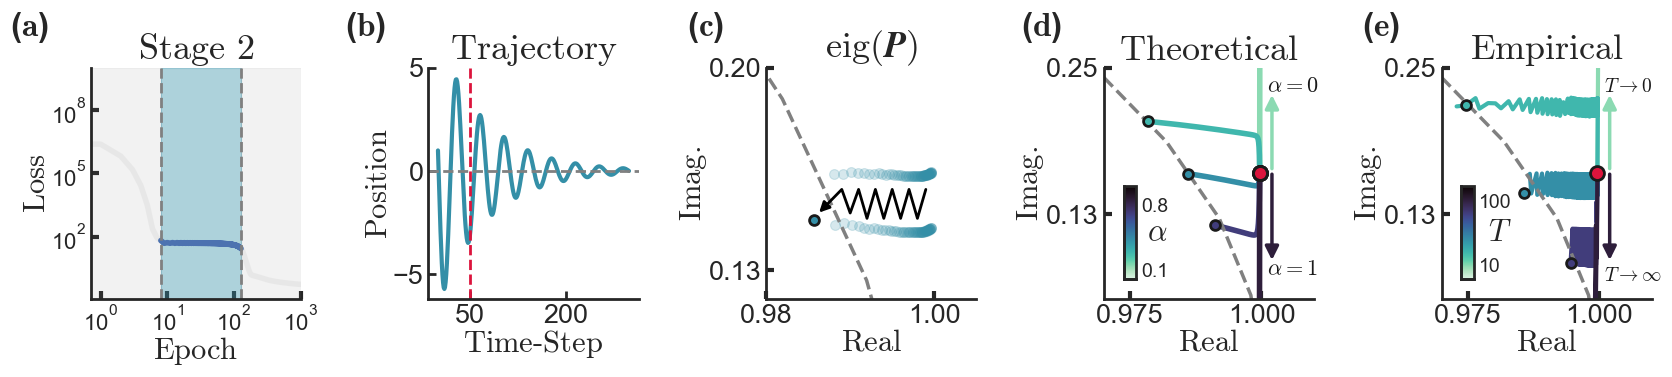

In [7]:
# === Load teacher model training history ===
with open('../data/data_closed.pkl', 'rb') as f:
    loss, model_his_parameters, grad = pickle.load(f)

with open('../data/eig_all_dict.pkl', 'rb') as f:
    eig_all_dict = pickle.load(f)

eig_vs = eig_all_dict['eig_vs']
eig_s = eig_all_dict['eig_s']
eig_b = eig_all_dict['eig_b']
eig_vb = eig_all_dict['eig_vb']


fig, ax = plt.subplots(1, 5, figsize=(17, 4.3), width_ratios=[1, 1, 1, 1, 1])

palette = sns.color_palette('mako_r')
# --------- Plot: Loss Curve --------- #
def plot_loss_curve(ax, test_loss):
    ax.plot(np.arange(9), test_loss[0, :9], color=sns.color_palette('deep')[7], lw=4, alpha=0.1)
    ax.plot(np.arange(8, 129), test_loss[0, 8:129], color=sns.color_palette('deep')[0], lw=4)
    ax.plot(np.arange(129, 1000), test_loss[0, 129:], color=sns.color_palette('deep')[7], lw=4, alpha=0.1)
    
    ax.axvspan(0, 8, color='grey', alpha=0.1)
    ax.axvspan(8, 129, color=palette[2], alpha=0.4)
    ax.axvspan(129, 1000, color='grey', alpha=0.1)
    ax.axvline(8, color='grey', ls='--')
    ax.axvline(129, color='grey', ls='--')

    ax.set(title=r"$\text{Stage 2}$", xscale='log', yscale='log', 
           xlim=(-10, 1010), ylim=(0.11, 1e10),
           xlabel=r'$\text{Epoch}$', ylabel=r"$\text{Loss}$")
    ax.set_xticks([1, 10, 100, 1000])
    ax.tick_params(axis='both', labelsize=16)
    ax.set_title(r'$\text{Stage 2} $',size=26)
    ax.set_xlabel(r'$\text{Epoch}$',size=22)
    ax.set_ylabel(r'$\text{Loss}$',size=22)

# --------- Plot: Trajectory --------- #
def plot_trajectory(ax, traj):
    ax.plot(traj, lw=3, color=palette[2])
    ax.axhline(0, color='grey', linestyle='--', lw=2)
    ax.set(title=r"$\text{Trajectory}$", xlabel=r"$\text{Time-Step}$", ylabel=r"$\text{Position}$")
    ax.set_yticks([-5, 0, 5])
    ax.tick_params(axis='both', which='major', width=2, length=6)
    ax.set_title(r"$\text{Trajectory}$",size=26)
    ax.set_xlabel(r"$\text{Time-Step}$",size=22)
    ax.set_ylabel(r"$\text{Position}$",size=22)

# --------- Plot: Eigenvalues with Zigzag Arrow --------- #
def plot_eig_with_arrow(ax, all_P, ep_of_stab):
    for idx in [ep_of_stab]:
        eigvals = np.linalg.eigvals(all_P[idx])
        ax.scatter(eigvals.real, eigvals.imag, s=50, color=palette[2],
                   edgecolor='k', linewidths=2, zorder=30)

    eigvals = np.linalg.eigvals(all_P[10])
    ax.scatter(eigvals.real, eigvals.imag, s=50, color=sns.color_palette('mako_r')[2],alpha=0.2)

    intermediate_eigvals = np.linalg.eigvals(all_P[12:ep_of_stab - 2])# [::2]
    ax.scatter(intermediate_eigvals.real, intermediate_eigvals.imag,
               s=50, color=palette[2], alpha=0.2)

    ax.axhline(0, color='grey', lw=1)
    ax.axvline(0, color='grey', lw=1)
    ax.plot(np.cos(np.linspace(0, 2*np.pi, 100)),
            np.sin(np.linspace(0, 2*np.pi, 100)), color='grey', ls='--', lw=2.5)

    zigzag = [(0.999, 0.158), (0.998, 0.148), (0.997, 0.158), (0.996, 0.148),
              (0.995, 0.158), (0.994, 0.148), (0.993, 0.158), (0.992, 0.148),
              (0.991, 0.158), (0.990, 0.14985), (0.989, 0.158), (0.9863, 0.15)]
    path = Path(zigzag, [Path.MOVETO] + [Path.LINETO]*(len(zigzag)-1))
    arrow = FancyArrowPatch(path=path, arrowstyle='-|>', color='black', mutation_scale=15, lw=2, zorder=30)
    ax.add_patch(arrow)

    ax.set(title=r'$\text{eig}(\mathbfit{P})$', xlim=(0.98, 1.005), ylim=(0.12, 0.2),
           xlabel=r'$\text{Real}$', ylabel=r'$\text{Imag}.$')
    ax.set_yticks([0.13, 0.2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_title(r'$\text{eig}(\mathbfit{P})$',size=26)
    ax.set_ylabel(r'$\text{Imag}.$',size=22)
    ax.set_xlabel(r'$\text{Real}$',size=22)

# --------- Model Definition --------- #
class ReduceModel(nn.Module):
    def __init__(self, a=0, b=0.01, c=0, d=0, alpha=0.01):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(a, dtype=torch.float32))
        self.b = nn.Parameter(torch.tensor(b, dtype=torch.float32))
        self.c = nn.Parameter(torch.tensor(c, dtype=torch.float32))
        self.d = nn.Parameter(torch.tensor(d, dtype=torch.float32))
        self.alpha = alpha

    def forward(self):
        a, b, c, d = self.a, self.b, self.c, self.d
        lam = a + (c * d) / (a**2 - 2*a - b + 1)
        r = (2*a - b + 1 + (-a-2)*lam + lam**2)**10
        n = (b+1)**2 + (b+3)**2 + (c*d + 2*b)**2 + (c*d + 3*b + 1)**2
        return self.alpha * r + (1 - self.alpha) * n

# --------- Optimization Loop --------- #
def optimize_and_track(a, b, c, d, alpha, lr, color, ax):
    model = ReduceModel(a, b, c, d, alpha)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    red_all_loss, red_model_parameters, all_gradients = [], [], []

    allep = 240
    if alpha == 0.48:
       allep=300 
    if alpha == 0.55:
        allep=190 
        
    for _ in range(allep):
        loss = model()
        red_all_loss.append(loss.item())
        red_model_parameters.append(deepcopy(model))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        all_gradients.append([p.grad.item() for p in model.parameters()])

    # Eigen root tracking
    z = [] 
    for m in red_model_parameters:
        a, b, c, d = m.a.item(), m.b.item(), m.c.item(), m.d.item()
        coeffs = [1, -a - 2, 2*a - b + 1, a*b - a - c*d]
        roots = np.roots(coeffs)
        # ax.scatter(np.real(roots), np.imag(roots), color=color)
        z.append(roots[0])
        
    ax.plot(np.real(z),np.imag(z),color=color,lw=4)
    ax.scatter(z[0].real, z[0].imag, marker='o',color='crimson',s=100,edgecolor='k', linewidths=2, zorder=30)
    ax.scatter(z[-1].real, z[-1].imag, s=50, color=color, edgecolor='k', linewidths=2, zorder=30)
        

# -------------------- Run Everything ------------------- #
plot_loss_curve(ax[0], test_loss)
plot_trajectory(ax[1], all_traj[1])
plot_eig_with_arrow(ax[2], all_P, ep_of_stab)

# Params from model
model = model_his_parameters[10]
m, z, u, v = model.M.detach().numpy().flatten(), model.Z.detach().numpy().flatten(), model.U.detach().numpy().flatten(), model.V.detach().numpy().flatten()
a, b, c, d = v @ u, z @ m, v @ m, z @ u



optimize_and_track(a, b, c, d, alpha=0.0,   lr=.001, color=palette[0], ax=ax[3])
optimize_and_track(a, b, c, d, alpha=0.48, lr=.001, color=palette[1], ax=ax[3])
optimize_and_track(a, b, c, d, alpha=0.52, lr=.001, color=palette[2], ax=ax[3])
optimize_and_track(a, b, c, d, alpha=0.55, lr=.001, color=palette[4], ax=ax[3])
optimize_and_track(a, b, c, d, alpha=1.0,   lr=.001, color=palette[5], ax=ax[3])


# --------- Labels --------- #
subplot_labels = [r'($\mathbf{a}$)', r'($\mathbf{b}$)', r'($\mathbf{c}$)', r'($\mathbf{d}$)', r'($\mathbf{e}$)']
for i, label in enumerate(subplot_labels):
    ax[i].text(-0.2, 1.25, label, transform=ax[i].transAxes,
               fontsize=24, fontweight='bold', va='top', ha='right', font="Arial")


arrow3 = FancyArrowPatch((1.002, 0.165), (1.002, 0.23), connectionstyle="arc3,rad=0", arrowstyle="-|>", lw=2.5,
                         color=palette[0], mutation_scale=20, zorder=30)
ax[3].add_patch(arrow3)
ax[3].text(x=1.001,y=0.23,s=r'$\alpha=0$',color='k',zorder=30)

arrow3 = FancyArrowPatch((1.002, 0.165), (1.002, 0.09), connectionstyle="arc3,rad=0", arrowstyle="-|>", lw=2.5,
                         color=palette[5], mutation_scale=20, zorder=30)
ax[3].add_patch(arrow3)
ax[3].text(x=1.001,y=0.08,s=r'$\alpha=1$',color='k',zorder=30)



# --------- Final Touch --------- #
ax[3].axhline(0, color='grey', lw=1)
ax[3].axvline(0, color='grey', lw=1)
ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)
ax[3].plot(np.cos(np.linspace(0, 2*np.pi, 100)),
           np.sin(np.linspace(0, 2*np.pi, 100)), color='grey', ls='--', lw=2.5)
ax[3].set_xlim(0.97, 1.01)
ax[3].set_ylim(0.06, 0.25)

# ax[3].set_title(r'$\text{eig}(\mathbfit{P})$')
ax[3].set_ylabel(r'$\text{Imag}.$',size=22)
ax[3].set_xlabel(r'$\text{Real}$',size=22)
ax[3].set_yticks([0.13, 0.25])
ax[3].set_title(r'$\text{Theoretical}$',size=26)

#############################################
# eig, _ = np.linalg.eig(vs_all_P[:108]) 
ax[4].plot(eig_vs.real[:,0], eig_vs.imag[:,0],color=sns.color_palette('mako_r')[0],lw=3) #s=50, 



# eig, _ = np.linalg.eig(s_all_P[:108]) 
ax[4].plot(eig_s.real[:,0], eig_s.imag[:,0],color=sns.color_palette('mako_r')[1],lw=3) #s=50, 
for idx in [106]:
        # eigvals = np.linalg.eigvals(s_all_P[idx])
        eigvals = eig_s[106]
        ax[4].scatter(eigvals.real, eigvals.imag, s=50, color=palette[1],
                   edgecolor='k', linewidths=2, zorder=30)


eig, _ = np.linalg.eig(all_P[10:ep_of_stab]) 
ax[4].plot(eig.real[:,0], eig.imag[:,0], color=sns.color_palette('mako_r')[2],lw=3) #s=50, 

for idx in [ep_of_stab]:
        eigvals = np.linalg.eigvals(all_P[idx])
        ax[4].scatter(eigvals.real, eigvals.imag, s=50, color=palette[2],
                   edgecolor='k', linewidths=2, zorder=30)

eigvals = np.linalg.eigvals(all_P[10])
ax[4].scatter(eigvals.real, eigvals.imag, marker='o',color='crimson',s=100,edgecolor='k', linewidths=2, zorder=30)

    
# eig, _ = np.linalg.eig(b_all_P[:111]) 
ax[4].plot(eig_b.real[:,0], eig_b.imag[:,0], color=sns.color_palette('mako_r')[4],lw=3)
for idx in [111]:
        # eigvals = np.linalg.eigvals(b_all_P[idx])
        eigvals = eig_b[idx]
        ax[4].scatter(eigvals.real, eigvals.imag, s=50, color=palette[4],
                   edgecolor='k', linewidths=2, zorder=30)

# eig, _ = np.linalg.eig(vb_all_P[:13]) 
ax[4].plot(eig_vb.real[:,0], eig_vb.imag[:,0],color=sns.color_palette('mako_r')[5],lw=3) #s=50, 

ax[4].axhline(0, color='grey', lw=1)
ax[4].axvline(0, color='grey', lw=1)
ax[4].spines['top'].set_visible(False)
ax[4].spines['right'].set_visible(False)
ax[4].plot(np.cos(np.linspace(0, 2*np.pi, 100)),
           np.sin(np.linspace(0, 2*np.pi, 100)), color='grey', ls='--', lw=2.5)
ax[4].set_xlim(0.97, 1.01)
ax[4].set_ylim(0.06, 0.25)

ax[4].set_title(r'$\text{Empirical}$',size=26) 
ax[4].set_ylabel(r'$\text{Imag}.$',size=22)
ax[4].set_xlabel(r'$\text{Real}$',size=22)
ax[4].set_yticks([0.13, 0.25])


from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
# Colorbar setup

# --- Colorbar on ax[4] ---
norm = Normalize(vmin=-10, vmax=120)
cmap = sns.color_palette("mako_r", as_cmap=True)
sm = ScalarMappable(norm=norm, cmap=cmap)

# Inset axes inside ax[3] (lower left, vertical)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cax = inset_axes(ax[4],
                 width="6%",  # width: 4% of parent_axes
                 height="40%",  # height: 30% of parent_axes
                 loc='lower left',
                 bbox_to_anchor=(0.03, 0.03, 1, 1),
                 bbox_transform=ax[4].transAxes)

cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=14)
cbar.set_ticks([10,   100])
cbar.set_label(r"$T$", rotation=0, labelpad=-8, fontsize=22,va='center')
#############################################


# --- Colorbar on ax[4] ---
norm = Normalize(vmin=0, vmax=1)
cmap = sns.color_palette("mako_r", as_cmap=True)
sm = ScalarMappable(norm=norm, cmap=cmap)

# Inset axes inside ax[3] (lower left, vertical)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cax = inset_axes(ax[3],
                 width="6%",  # width: 4% of parent_axes
                 height="40%",  # height: 30% of parent_axes
                 loc='lower left',
                 bbox_to_anchor=(0.03, 0.03, 1, 1),
                 bbox_transform=ax[3].transAxes)



cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=14)
cbar.set_ticks([0.1,   0.8])
cbar.set_label(r"$\alpha$", rotation=0, labelpad=-8, fontsize=22,va='center')


arrow3 = FancyArrowPatch((1.002, 0.165), (1.002, 0.23), connectionstyle="arc3,rad=0", arrowstyle="-|>", lw=2.5,
                         color=palette[0], mutation_scale=20, zorder=30)
ax[4].add_patch(arrow3)
ax[4].text(x=1.001,y=0.23,s=r'$T \to 0$',color='k',zorder=30,size=14)

arrow3 = FancyArrowPatch((1.002, 0.165), (1.002, 0.09), connectionstyle="arc3,rad=0", arrowstyle="-|>", lw=2.5,
                         color=palette[5], mutation_scale=20, zorder=30)
ax[4].add_patch(arrow3)
ax[4].text(x=1.001,y=0.075,s=r'$T \to \infty$',color='k',zorder=30,size=14)

ax[1].axvline(x=50,ls='--',color='crimson')

ax[1].set_xticks([50,200])

plt.tight_layout()
sns.despine()
# plt.savefig('../figs/fig_4.pdf',bbox_inches=None)# 
plt.show()


In [8]:
arr_betas = [0, .5, 2, 5]
N = 100
dic_h_d = {}
system = k_integrator_torch(k=2,dt=1,c=1,m=1,)

with open('../data/data_closed.pkl', 'rb') as f:
    org_loss, model_his_parameters, grad = pickle.load(f)

init_model  = model_his_parameters[130]

for beta in arr_betas:

    model = P_Model(N=N, g=0, rank=1,  system=system) # Instantiate the model
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Instantiate the optimizer

    with torch.no_grad():
        model.U.copy_(nn.Parameter(init_model.U.detach())) 
        model.V.copy_(nn.Parameter(init_model.V.detach())) 
        model.M.copy_(nn.Parameter(init_model.M.detach())) 
        model.Z.copy_(nn.Parameter(init_model.Z.detach()))

    num_epochs = 1000
    loss,model_his_parameters, grad = train_model_p(model,
                                              optimizer,
                                              teacher=None,
                                              white_noise=None,
                                              beta=beta,
                                              w_grad_clip=True,
                                              num_epochs=num_epochs,
                                              batch_size=100,
                                              num_steps=50,
                                              clamp=False)

    _all_P = []
    for ep in range(num_epochs):
        model = model_his_parameters[ep]
        P = create_p_matrix_from_low_rank(model.system, model.N, model.M, model.Z, model.U, model.V, model.W_random)
        _all_P.append(P.detach().numpy())
    
    eig,_ = np.linalg.eig(np.array(_all_P))
    stab = np.all(np.abs(eig) < 1, axis=1).astype(int)
    
    try:
        for i in range(num_epochs):
            if stab[i] == 1 and all(stab[i:] == [1] * (len(stab) - i)):
                ep_of_stab = i
                break
    except:
        ep_of_stab = num_epochs+1

    dic_h_d[beta] = [loss, model_his_parameters, grad, _all_P, ep_of_stab]

        


dic_l_d = {}
with open('../data/data_closed.pkl', 'rb') as f:
    loss, model_his_parameters, grad = pickle.load(f)

init_model  = model_his_parameters[130]

for beta in arr_betas:
    
    model = init_model
    m, z, u, v = model.M.detach().numpy().flatten(), model.Z.detach().numpy().flatten(), model.U.detach().numpy().flatten(), model.V.detach().numpy().flatten()
    model = P_Model_eff(init_sig_zm=z@m, init_sig_zu=z@u, init_sig_vm=v@m, init_sig_vu=v@u)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Instantiate the optimizer
    num_epochs = 1000
    batch_size = 100
    loss, model_his_parameters, grad = train_model_p_eff(model, optimizer, teacher=None, white_noise=None, beta=beta,
                                                   w_grad_clip=1, num_epochs=num_epochs, batch_size=batch_size, num_steps=50, clamp=False)
    
    _all_P = []
    for ep in range(num_epochs):
        P = create_p_effective(model_his_parameters[ep])
        _all_P.append(P)
    
    eig,_ = np.linalg.eig(np.array(_all_P))
    stab = np.all(np.abs(eig) < 1, axis=1).astype(int)
    
    try:
        for i in range(num_epochs):
            if stab[i] == 1 and all(stab[i:] == [1] * (len(stab) - i)):
                ep_of_stab = i
                break
    except:
        ep_of_stab = num_epochs+1
        
    dic_l_d[beta] = [loss, model_his_parameters, grad, _all_P, ep_of_stab]
    

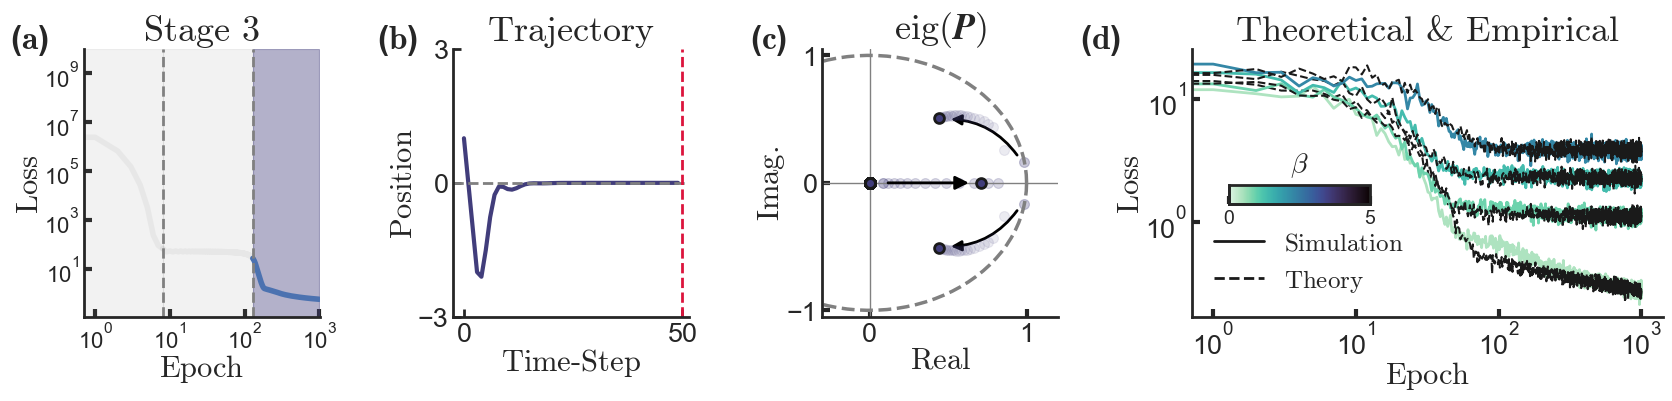

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(17, 4.3), width_ratios=[1, 1, 1, 2])

# === Panel (a): Test Loss ===
ax[0].plot(np.arange(9),     test_loss[0, :9],     color=sns.color_palette('deep')[7], lw=4, alpha=0.1)
ax[0].plot(np.arange(8, 129), test_loss[0, 8:129], color=sns.color_palette('deep')[7], lw=4, alpha=0.1)
ax[0].plot(np.arange(129, 1000), test_loss[0, 129:], color=sns.color_palette('deep')[0], lw=4)

ax[0].axvspan(0, 8, color='grey', alpha=0.1)
ax[0].axvspan(8, 129, color='grey', alpha=0.1)
ax[0].axvspan(129, 1000, color=sns.color_palette('mako_r')[4], alpha=0.4)

ax[0].axvline(x=8, color='grey', ls='--')
ax[0].axvline(x=129, color='grey', ls='--')

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(-10, 1010)
ax[0].set_ylim(0.11, 1e10)
ax[0].set_title(r"$\text{Stage 3}$", size=26)
ax[0].set_xlabel(r'$\text{Epoch}$', size=22)
ax[0].set_ylabel(r"$\text{Loss}$", size=22)
ax[0].set_xticks([1, 10, 100, 1000])
ax[0].tick_params(axis='both', labelsize=16)

# === Panel (b): Trajectory ===
ax[1].plot(all_traj[2], lw=3, color=sns.color_palette('mako_r')[4])
ax[1].axhline(0, color='grey', ls='--', lw=2)
# ax[1].set_xticks([50, 200])
ax[1].set_yticks([-3, 0, 3])
ax[1].tick_params(axis='both', width=2, length=6)

ax[1].set_title(r"$\text{Trajectory}$", size=26)
ax[1].set_xlabel(r"$\text{Time-Step}$", size=22)
ax[1].set_ylabel(r"$\text{Position}$", size=22)
ax[1].axvline(x=50, ls='--', color='crimson')

# === Panel (c): eig(P) ===
# Plot earlier eigenvalues (light)
eig, _ = np.linalg.eig(all_P[130])
ax[2].scatter(eig.real, eig.imag, s=50, color=sns.color_palette('mako_r')[4], alpha=0.2)

eig, _ = np.linalg.eig(all_P[130:][::40])
ax[2].scatter(eig.real[:, :2], eig.imag[:, :2], s=50, color=sns.color_palette('mako_r')[4], alpha=0.1)

eig, _ = np.linalg.eig(all_P[130:180][::4])
ax[2].scatter(eig.real[:, 2], eig.imag[:, 2], s=50, color=sns.color_palette('mako_r')[4], alpha=0.2)

# Final stable eigenvalues (highlighted)
eig, _ = np.linalg.eig(all_P[-1])
ax[2].scatter(eig.real, eig.imag, s=50, color=sns.color_palette('mako_r')[4], edgecolor='k', linewidths=2, zorder=30)

# Circle for stability
theta = np.linspace(0, 2 * np.pi, 100)
ax[2].plot(np.cos(theta), np.sin(theta), color='grey', ls='--', lw=2.5, alpha=1)

ax[2].axhline(0, color='grey', lw=1)
ax[2].axvline(0, color='grey', lw=1)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)

ax[2].set_xlim(-0.3, 1.2)
ax[2].set_ylim(-1.05, 1.05)
ax[2].set_title(r'$\text{eig}(\mathbfit{P})$', size=26)
ax[2].set_xlabel(r'$\text{Real}$', size=22)
ax[2].set_ylabel(r'$\text{Imag}.$', size=22)

# Arrows showing movement in eig space
ax[2].add_patch(FancyArrowPatch((0.1, 0.0), (0.65, 0.0), connectionstyle="arc3,rad=0", arrowstyle="-|>", lw=2, color='black', mutation_scale=20, zorder=40))
ax[2].add_patch(FancyArrowPatch((0.95,  0.2), (0.5, 0.5), connectionstyle="arc3,rad=.25", arrowstyle="-|>", lw=2, color='black', mutation_scale=15, zorder=0))
ax[2].add_patch(FancyArrowPatch((0.95, -0.2), (0.5, -0.5), connectionstyle="arc3,rad=-.25", arrowstyle="-|>", lw=2, color='black', mutation_scale=15, zorder=0))

# === Panel (d): Loss comparison across β ===
skipy = 1
labels_plotted = False

for idx, beta in enumerate(arr_betas):
    color = colors[[0, 1, 2, 4][idx]]
    
    ax[3].plot(dic_h_d[beta][0][::skipy], color=color, label=r'$P$' if idx > 0 else None)
    ax[3].plot(dic_l_d[beta][0][::skipy], ls='--', color='k', lw=1.5, label=r'$P_{\text{eff}}$' if idx > 0 else None)

# Set log scales
ax[3].set_xscale('log')
ax[3].set_yscale('log')

# Disable minor ticks
ax[3].xaxis.set_minor_locator(NullLocator())
ax[3].yaxis.set_minor_locator(NullLocator())

# Axis labels and title
ax[3].set_xlabel(r'$\text{Epoch}$', size=22)
ax[3].set_ylabel(r"$\text{Loss}$", size=22)
ax[3].set_title(r"$\text{Theoretical & Empirical}$", size=26)

# === Legend ===
ax[3].legend(
    handles=[
        Line2D([0], [0], color='k', linestyle='-', lw=2, zorder=30),
        Line2D([0], [0], color='k', linestyle='--', lw=2, zorder=30)
    ],
    labels=[r'$\text{Simulation}$', r'$\text{Theory}$'],
    loc='lower left',
    frameon=False,
    fontsize=18
)

# === Colorbar indicating β values ===
norm = Normalize(vmin=0, vmax=5)
cmap = sns.color_palette("mako_r", as_cmap=True)
sm = ScalarMappable(norm=norm, cmap=cmap)


cax = inset_axes(
    ax[3], width="30%", height="7%", loc='lower left',
    bbox_to_anchor=(0.05, 0.37, 1, 1), bbox_transform=ax[3].transAxes
)
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_ticks([0, 5])
cbar.set_label(r"$\beta$", rotation=0, labelpad=-45, fontsize=20, va='center')

# === Subplot labels (a), (b), ... ===
subplot_labels = [r'($\mathbf{a}$)', r'($\mathbf{b}$)', r'($\mathbf{c}$)', r'($\mathbf{d}$)']
for i, label in enumerate(subplot_labels):
    ax[i].text(
        -0.15, 1.1, label,
        transform=ax[i].transAxes,
        fontsize=24, fontweight='bold',
        va='top', ha='right', font="Arial"
    )

# === Layout and Display ===

plt.tight_layout()
sns.despine()
# plt.savefig('../figs/fig_5.pdf',bbox_inches=None)# 'tight'
plt.show()


In [10]:
total_time = 30.0    # total time
sampling_rate = 10 # 10   # Hz
n_samples = int(total_time * sampling_rate)
t = np.linspace(0, total_time, n_samples, endpoint=False)

# Load the saved arrays
with open('../data/closed_loop_tracking_data.pkl', 'rb') as f:
    data = pickle.load(f)

ref = data['ref']
net_ot = data['net_ot']
freqs_to_title = data['freqs_to_title']
all_eigs = data['all_eigs']
loss = data['loss']


with open('../data/saved_arrays.pkl', 'rb') as f:
    data = pickle.load(f)

r_x = data['r_x']
r_y = data['r_y']
states_x = data['states_x']
states_y = data['states_y']
test_losses = data['test_losses']
all_loss = data['2_frq_loss']


file_path = "../data/adam_all_loss.pkl"
with open(file_path, "rb") as f:  # Note the 'rb' for reading binary
    all_loss = pickle.load(f)


S,E = 900,1100

# Extract segments
data_om1 = all_loss[S:E, 0]
data_om2 = all_loss[S:E, 1]


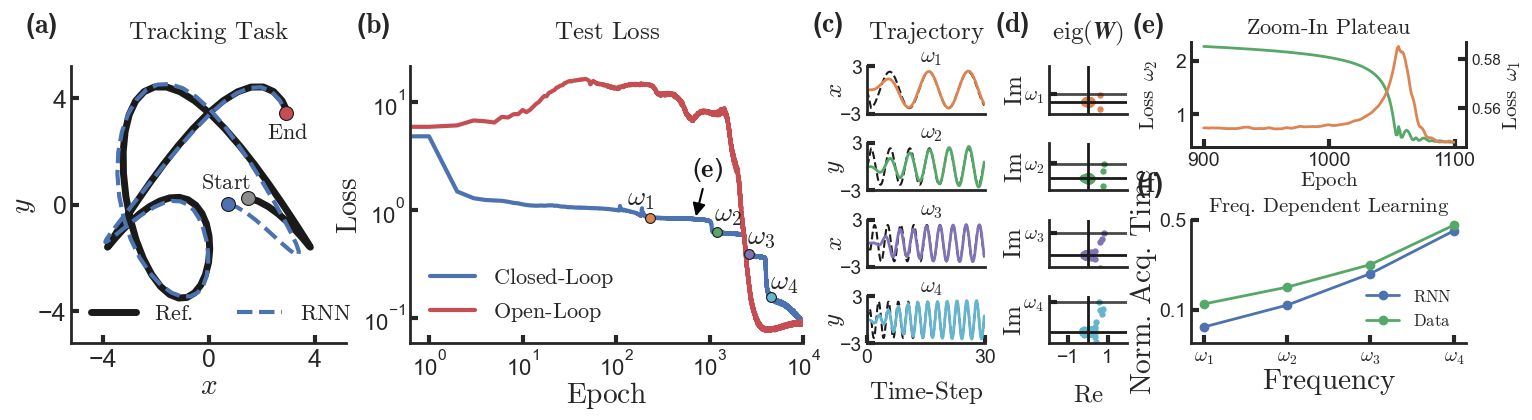

In [11]:
# === Figure and GridSpec ===
fig = plt.figure(figsize=(18, 3.6))
gs = gridspec.GridSpec(
    4, 5,
    width_ratios=[0.7, 1.0, 0.3, 0.2, 0.7],
    height_ratios=[1, 1, 1, 1],
    wspace=0.28, hspace=0.62
)

# === (a) Tracking Panel ===
ax_track = plt.subplot(gs[:, 0])
start, end = 48, 125
x, y = states_x[start:end], states_y[start:end]

ax_track.plot(r_x[start:end], r_y[start:end], color='k', lw=5, label=r'$\text{Ref.}$')
ax_track.plot(x, y, linestyle='--', color=sns.color_palette('deep')[0], lw=3, label=r'$\text{RNN}$')
ax_track.scatter(r_x[start], r_y[start], c=sns.color_palette('deep')[7], s=100, edgecolors='k', zorder=30)
ax_track.scatter(x[0], y[0], c=sns.color_palette('deep')[0], s=100, edgecolors='k', zorder=30)
ax_track.scatter(x[-1], y[-1], c=sns.color_palette('deep')[3], s=100, edgecolors='k', zorder=30)
ax_track.text(-0.3, 0.63, r'$\text{Start}$')
ax_track.text(2.2, 2.5, r'$\text{End}$')

ax_track.set(
    xlabel=r"$x$", ylabel=r"$y$",
    xticks=[-4, 0, 4], yticks=[-4, 0, 4],
    xlim=[-5.2, 5.2], ylim=[-5.2, 5.2]
)
ax_track.set_title(r'$\text{Tracking Task}$', fontsize=18, pad=20)
ax_track.legend(fontsize=16, loc='lower left', frameon=False, ncols=2)
ax_track.tick_params(axis='both', labelsize=18)
sns.despine(ax=ax_track)

# === (b) Loss Plot ===
ax_loss = plt.subplot(gs[:, 1])
ax_loss.plot(loss, color=sns.color_palette('deep')[0], lw=3, label=r'$\text{Closed-Loop}$')
ax_loss.plot(test_losses, color=sns.color_palette('deep')[3], lw=3, label=r'$\text{Open-Loop}$')

highlight_epochs = [230, 1200, 2600, 4500]
colors_idx = [1, 2, 4, 9]
omega_labels = [r'$\omega_{1}$', r'$\omega_{2}$', r'$\omega_{3}$', r'$\omega_{4}$']
y_offsets = [0.27, 0.18, 0.1, 0.03]

for ep, idx, lbl, offset in zip(highlight_epochs, colors_idx, omega_labels, y_offsets):
    ax_loss.scatter(ep, loss[ep], color=sns.color_palette('deep')[idx], s=50, edgecolors='k', zorder=36)
    ax_loss.text(ep - 100, loss[ep] + offset, lbl, fontsize=20, zorder=30)

ax_loss.set(
    xscale='log', yscale='log',
    xlabel=r'$\text{Epoch}$', ylabel=r"$\text{Loss}$",
    xticks=[1, 10, 100, 1000, 10000],
    xlim=(0, 10000)
)
ax_loss.xaxis.set_minor_locator(NullLocator())
ax_loss.yaxis.set_minor_locator(NullLocator())
ax_loss.set_title(r'$\text{Test Loss}$', fontsize=18, pad=20)
ax_loss.legend(fontsize=16, loc='lower left', frameon=False)
ax_loss.tick_params(axis='both', labelsize=16)
sns.despine(ax=ax_loss)

# === (c) Small Trajectories ===
small_axes = [plt.subplot(gs[i, 2]) for i in range(4)]
for i, ax in enumerate(small_axes):
    ax.plot(t, ref[i], '--', color='k', lw=1.5)
    ax.plot(t, net_ot[i], color=sns.color_palette('deep')[colors_idx[i]], lw=2)
    ax.set_xlim(0, 30.1)
    ax.set_xticks([] if i < 3 else [0, 30])
    ax.set_yticks([-3, 3])
    ax.set_ylabel(r'$x$' if i % 2 == 0 else r'$y$', fontsize=18, labelpad=-5)
    if i == 3:
        ax.set_xlabel(r'$\text{Time-Step}$', fontsize=18, labelpad=9)
    ax.text(0.45, 1.1, omega_labels[i], transform=ax.transAxes, fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    sns.despine(ax=ax)

small_axes[0].set_title(r'$\text{Trajectory}$', fontsize=18, pad=20)

# === (d) Eigenvalue Panels ===
tiny_axes = [plt.subplot(gs[i, 3]) for i in range(4)]
for i, ax in enumerate(tiny_axes):
    eig = all_eigs[i]
    ax.scatter(eig.real, eig.imag, color=sns.color_palette('deep')[colors_idx[i]], s=14)
    ax.axhline(0, color='k', lw=2)
    ax.axvline(0, color='k', lw=2)
    ax.axhline(freqs_to_title[i], color='k', alpha=0.8)
    ax.set(
        xlim=(-2, 2), ylim=(-1, 3),
        yticks=[round(freqs_to_title[i], 2)],
        yticklabels=[omega_labels[i]]
    )
    if i == 3:
        ax.set_xticks([-1, 1])
        ax.set_xlabel(r'$\text{Re}$', fontsize=18, labelpad=12)
    else:
        ax.set_xticks([])
    ax.set_ylabel(r'$\text{Im}$', fontsize=18, labelpad=-2)
    ax.tick_params(axis='both', labelsize=14)
    sns.despine(ax=ax)

tiny_axes[0].set_title(r'$\text{eig}(\mathbfit{W})$', fontsize=18, pad=20)

# === (e) Zoom-in Plateau ===
medium_axes = [plt.subplot(gs[0:2, 4]), plt.subplot(gs[2:4, 4])]

# Left y-axis
medium_axes[0].plot(np.arange(S, E), data_om2, color=sns.color_palette('deep')[2], label=r'$\omega_2$')
medium_axes[0].set_ylabel(r'$\text{Loss}\,\,\,\omega_2$', fontsize=15, labelpad=11)

# Right y-axis
ax2 = medium_axes[0].twinx()
ax2.plot(np.arange(S, E), data_om1, color=sns.color_palette('deep')[1], label=r'$\omega_1$')
ax2.set_ylabel(r'$\text{Loss}\,\,\,\omega_1$', fontsize=15)

# Styling
medium_axes[0].set_xlabel(r'$\text{Epoch}$', fontsize=15)
medium_axes[0].set_title(r'$\text{Zoom-In Plateau}$', fontsize=16)
medium_axes[0].tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=11)

# Move both axes up
pos1, pos2 = medium_axes[0].get_position(), ax2.get_position()
new_bottom = pos1.y0 + 0.12
new_height = pos1.height * 0.85
medium_axes[0].set_position([pos1.x0, new_bottom, pos1.width, new_height])
ax2.set_position([pos2.x0, new_bottom, pos2.width, new_height])
sns.despine(ax=medium_axes[0])
sns.despine(ax=ax2)
medium_axes[0].spines['right'].set_visible(True)
ax2.spines['right'].set_visible(True)

# === (f) Frequency Dependent Learning ===
medium_axes[1].plot(np.array(highlight_epochs) / 10000, '.-', ms=12, color=sns.color_palette('deep')[0], label=r'$\text{RNN}$')
medium_axes[1].plot(np.array([2.5, 4, 6, 9.5]) / 20, '.-', ms=12, color=sns.color_palette('deep')[2], label=r'$\text{Data}$')
medium_axes[1].set(
    xticks=[0, 1, 2, 3],
    xticklabels=omega_labels,
    ylim=(-0.05, 0.5),
    yticks=[0.1, 0.5],
    xlabel=r'$\text{Frequency}$',
    ylabel=r'$\text{Norm. Acq. Time}$'
)
medium_axes[1].tick_params(axis='both', labelsize=14)
medium_axes[1].legend(fontsize=12, loc='lower right', frameon=False)
medium_axes[1].set_title(r'$\text{Freq. Dependent Learning}$', fontsize=15)
sns.despine(ax=medium_axes[1])

# === Subplot Labels ===
labels = [r'($\mathbf{a}$)', r'($\mathbf{b}$)', r'($\mathbf{c}$)', r'($\mathbf{d}$)', r'($\mathbf{e}$)', r'($\mathbf{f}$)']
positions = [
    (ax_track, (-0.05, 1.2)),
    (ax_loss, (-0.05, 1.2)),
    (small_axes[0], (-0.2, 2.2)),
    (tiny_axes[0], (-0.25, 2.2)),
    (medium_axes[0], (-0.10, 1.295)),
    (medium_axes[1], (-0.10, 1.4))
]
for ax, (x, y), label in zip(*zip(*positions), labels):
    ax.text(x, y, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='right', font="Arial")

# Arrow annotation pointing to (e)
ax_loss.annotate(
    r'($\mathbf{e}$)', xy=(700, loss[700]), xytext=(650, loss[700] + 1.24),
    arrowprops=dict(arrowstyle='-|>', color='black', lw=1.5),
    fontsize=19, color='k', zorder=30
)

plt.tight_layout()
# plt.savefig('../figs/fig_6.pdf', bbox_inches='tight')
plt.show()
